# Assessment Preparation Challenge 2: Mapping a Remote Website

---

## About This Challenge

| | |
|---|---|
| **Purpose** | Practice web crawling skills on real websites |
| **Graded?** | No - this is purely for your benefit |
| **Solutions provided?** | No - similar tasks appear in the final assessment |
| **Difficulty** | Medium (builds on Week 2 lab exercises) |
| **Prerequisites** | Complete Week2-exercise.ipynb first |
| **Time estimate** | 30-45 minutes |

---

## What You'll Learn

By completing this challenge, you will:

1. **Adapt** local file crawlers to work with remote URLs
2. **Handle** different URL formats (relative vs absolute)
3. **Filter** links to stay within a specific domain
4. **Limit** crawl depth to avoid infinite loops
5. **Create** readable network visualizations
6. **Analyze** website structure using PageRank and HITS

---

## Setup

Run this cell first to import all required libraries.

In [1]:
# Run this cell to load all dependencies
# (You can run cells with Shift+Enter or the RUN button above)

import networkx as nx
import matplotlib.pyplot as plt
import os
import time
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pprint as pp
import requests

print("All libraries loaded successfully!")

All libraries loaded successfully!


---

# Step 1: Understanding URL Formats

Before crawling remote sites, you need to understand how URLs work. This is **different** from local files!

## Types of Links You'll Encounter

| Link Type | Example | What It Means |
|-----------|---------|---------------|
| **Absolute** | `https://example.com/about` | Complete URL - use as-is |
| **Relative** | `/about` | Path only - needs domain prepended |
| **Fragment** | `/page#section` | Links to section - remove `#section` |
| **Query** | `/page?id=123` | Has parameters - often remove |
| **External** | `https://twitter.com/user` | Different domain - usually skip |
| **Email** | `mailto:info@example.com` | Not a page - always skip |

## Practice: Test Your Understanding

If you're on the page `https://example.com/products/shoes`, what would these links become?

1. `/contact` → ?
2. `../about` → ?
3. `https://facebook.com` → ?

<details>
<summary>Click to see answers</summary>

1. `/contact` → `https://example.com/contact` (relative path from root)
2. `../about` → `https://example.com/about` (go up one directory)
3. `https://facebook.com` → SKIP! (external domain)

</details>

---

# Step 2: Understanding the Helper Functions

We provide three helper functions to handle URL processing. **Read through each one carefully** - understanding them is key to completing the challenge!

## Function 1: `domain_only(url)`

**Purpose**: Extract just the domain from a full URL.

**Why we need it**: To check if a link stays within our target website.

**Examples**:
- `"https://bbc.co.uk/news/weather"` → `"bbc.co.uk"`
- `"https://www.example.com/page"` → `"www.example.com"`

In [2]:
def domain_only(full_url):
    """
    Extract the domain from a full URL.
    
    Example: 'https://bbc.co.uk/news' -> 'bbc.co.uk'
    """
    # Remove the protocol (https:// or http://)
    without_https = full_url.lstrip("https").lstrip("http").lstrip("://")
    
    # Find where the path starts (first /)
    end_of_domain = without_https.find("/") if "/" in without_https else len(without_https)
    
    # Return just the domain part
    return without_https[0:end_of_domain]

# Test the function - all should print "tests passed"
assert domain_only("https://bbc.co.uk/") == "bbc.co.uk"
assert domain_only("https://bbc.co.uk") == "bbc.co.uk"
assert domain_only("https://bbc.co.uk/news") == "bbc.co.uk"
assert domain_only("http://twitter.com/account") == "twitter.com"
print("domain_only() tests passed!")

domain_only() tests passed!


## Function 2: `protocol_only(url)`

**Purpose**: Get `http://` or `https://` from a URL.

**Why we need it**: To reconstruct full URLs from relative links.

In [3]:
def protocol_only(full_url):
    """
    Extract the protocol (http:// or https://) from a URL.
    
    Example: 'https://bbc.co.uk/' -> 'https://'
    """
    if "https://" in full_url:
        return "https://" 
    elif "http://" in full_url:
        return "http://" 
    else:
        return ""

# Test the function
assert protocol_only("https://bbc.co.uk/") == "https://"
assert protocol_only("http://bbc.co.uk") == "http://"
assert protocol_only("bbc.co.uk/news") == ""
print("protocol_only() tests passed!")

protocol_only() tests passed!


## Function 3: `cleanup_the_link(page_url, link_address)`

**Purpose**: Convert any link format to a clean, absolute URL.

**What it does**:
1. Handles relative links (adds domain)
2. Filters external links (optional)
3. Removes fragments (`#section`)
4. Removes query strings (`?param=value`)
5. Removes trailing slashes for consistency

**This is the most important function!** Study it carefully.

In [4]:
def cleanup_the_link(page_url, link_address, keep_external_links=False):
    """
    Clean up a link found on a page and convert to absolute URL.
    
    Args:
        page_url: The URL of the page where we found this link
        link_address: The href value of the link
        keep_external_links: If False, replace external links with page_url
    
    Returns:
        Cleaned absolute URL
    """
    
    # Handle relative links (no http in them)
    if "http" not in link_address: 
        # Internal link like '/about' or 'products.html'
        # Combine protocol + domain + link
        link_address = protocol_only(page_url) + domain_only(page_url) + link_address
        
    else:
        # Absolute link - check if it's external
        if domain_only(link_address) != domain_only(page_url) and keep_external_links == False:
            # External link to different domain - replace with current page
            link_address = page_url
    
    # Skip email links
    if "mailto" in link_address:
        link_address = page_url
    
    # Remove fragment identifiers (#section)
    if "#" in link_address:
        link_address = link_address[0:link_address.find("#")]
    
    # Remove query parameters (?id=123)
    if "?" in link_address:
        link_address = link_address[0:link_address.find("?")]
        
    # Remove trailing slash for consistency
    link_address = link_address.rstrip("/")
        
    return link_address

# Test the function
assert cleanup_the_link("https://bbc.co.uk/", "/news") == "https://bbc.co.uk/news"
assert cleanup_the_link("https://bbc.co.uk", "/news") == "https://bbc.co.uk/news"
assert cleanup_the_link("https://bbc.co.uk/news", "/weather") == "https://bbc.co.uk/weather"
assert cleanup_the_link("https://twitter.com", "https://bbc.co.uk/") == "https://twitter.com"  # External filtered
assert cleanup_the_link("https://twitter.com", "https://bbc.co.uk/", True) == "https://bbc.co.uk"  # External kept
assert cleanup_the_link("https://bbc.co.uk/news", "/weather#footer") == "https://bbc.co.uk/weather"  # Fragment removed
assert cleanup_the_link("https://bbc.co.uk/news", "/mailto:info@bbc.co.uk") == "https://bbc.co.uk/news"  # Email skipped
assert cleanup_the_link("https://bbc.co.uk/news", "/weather?city=edinburgh") == "https://bbc.co.uk/weather"  # Query removed
print("cleanup_the_link() tests passed!")

cleanup_the_link() tests passed!


---

# Step 3: Build Your Crawler Step-by-Step

Now we'll build the crawler incrementally. Complete each sub-step before moving to the next.

## Step 3a: Visit One Page and Get All Links

First, let's just visit the starting page and see what links we find.

In [5]:
def visit_page_and_return_dictionary(page_url, keep_external_links=False):
    """
    Visit a web page and return all cleaned links.
    
    Args:
        page_url: URL to visit
        keep_external_links: Whether to include links to other domains
    
    Returns:
        Dictionary with 'address' and 'links_to' keys
    """
    link_urls = []
    print(f"Looking for links in {page_url}")
    
    try:
        # Request the page with a timeout
        html_of_website = requests.get(page_url, timeout=10).content.decode()    
    except Exception as e:
        # If something went wrong, return empty links
        print(f"  Error: {e}")
        return {'address': page_url, 'links_to': []}
    
    # Parse HTML and find all links
    soup = BeautifulSoup(html_of_website, 'html.parser')
    links = soup.find_all('a')
    
    for link in links:
        link_url = link.get('href', default=page_url)
        
        # Clean up the link
        link_url = cleanup_the_link(page_url, link_url, keep_external_links)
        link_urls.append(link_url)
        
    # Remove duplicates
    link_urls = list(set(link_urls))
        
    return {'address': page_url, 'links_to': link_urls}

# Test with a simple website
test_result = visit_page_and_return_dictionary("https://www.marysmilkbar.com/yourvisit")
print(f"\nFound {len(test_result['links_to'])} links")
pp.pprint(test_result)

Looking for links in https://www.marysmilkbar.com/yourvisit

Found 6 links
{'address': 'https://www.marysmilkbar.com/yourvisit',
 'links_to': ['https://www.marysmilkbar.com/cart',
              'https://www.marysmilkbar.com',
              'https://www.marysmilkbar.com/shop',
              'https://www.marysmilkbar.com/yourvisit',
              'https://www.marysmilkbar.com/our-story',
              'https://www.marysmilkbar.com/dietinfo']}


## Step 3b: Add the Crawl Loop

Now let's add the frontier management to crawl multiple pages.

In [6]:
def analyse_website(starting_website, keep_external_links=False, max_pages=20):
    """
    Crawl a website starting from a given URL.
    
    Args:
        starting_website: URL to start crawling
        keep_external_links: Whether to follow external links
        max_pages: Maximum pages to crawl (to prevent infinite crawling)
    
    Returns:
        List of page info dictionaries
    """
    pages_we_visited = []
    pages_to_visit = [starting_website] 
    pages_scraped_info = []

    # Keep crawling until no more pages or we hit the limit
    while len(pages_to_visit) > 0 and len(pages_we_visited) < max_pages:
        # Get next page from the frontier
        next_page_to_visit = pages_to_visit.pop() 
        
        # Visit the page
        page_info = visit_page_and_return_dictionary(next_page_to_visit, keep_external_links)
        pages_scraped_info.append(page_info)

        # Mark as visited
        pages_we_visited.append(page_info['address']) 
        
        # Add new links to frontier
        for link_url in page_info['links_to']:
            if link_url not in pages_we_visited and link_url not in pages_to_visit:
                pages_to_visit.append(link_url)

        # Remove duplicates from frontier
        pages_to_visit = list(set(pages_to_visit))
        
        # Be polite - add a small delay
        time.sleep(0.5)

    print(f"\nCrawl complete! Visited {len(pages_we_visited)} pages.")
    return pages_scraped_info

## Step 3c: Test with a Small Website

Let's test our crawler with a small, simple website.

In [7]:
# Crawl a small website (limited to 10 pages)
scraped_pages = analyse_website("https://www.marysmilkbar.com/", max_pages=10)

# Show the results
print("\nPages discovered:")
for page in scraped_pages:
    print(f"  {page['address']} -> {len(page['links_to'])} links")

Looking for links in https://www.marysmilkbar.com/
Looking for links in https://www.marysmilkbar.com/dietinfo
Looking for links in https://www.marysmilkbar.com/our-story
Looking for links in https://www.marysmilkbar.com/shop
Looking for links in https://www.marysmilkbar.com/yourvisit
Looking for links in https://www.marysmilkbar.com
Looking for links in https://www.marysmilkbar.com/cart

Crawl complete! Visited 7 pages.

Pages discovered:
  https://www.marysmilkbar.com/ -> 6 links
  https://www.marysmilkbar.com/dietinfo -> 6 links
  https://www.marysmilkbar.com/our-story -> 6 links
  https://www.marysmilkbar.com/shop -> 6 links
  https://www.marysmilkbar.com/yourvisit -> 6 links
  https://www.marysmilkbar.com -> 6 links
  https://www.marysmilkbar.com/cart -> 6 links


---

# Step 4: Creating and Visualizing the Graph

Now let's create a NetworkX graph and visualize it.

## Basic Graph Creation

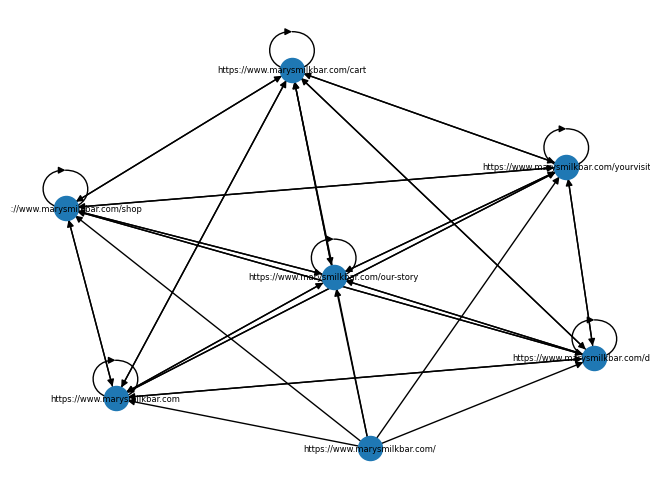


Note: The graph might look messy - we'll improve it next!


In [8]:
def graph_site_info(pages_info):
    """
    Create and display a graph from crawled page data.
    """
    graph = nx.DiGraph()

    # Add edges for each link
    for page in pages_info:
        link_origin = page['address']
        all_links = page['links_to']
        for link_destination in all_links:
            graph.add_edge(link_origin, link_destination)

    # Draw the graph
    positions = nx.spring_layout(graph)
    nx.draw(graph, positions, with_labels=True, font_size=6) 
    plt.show()
    
    return graph

# Create the basic graph
graph = graph_site_info(scraped_pages)
print("\nNote: The graph might look messy - we'll improve it next!")

## Making the Graph Readable

The default graph is often messy. Here are tips to improve it:

### Tip 1: Shorten URL Labels

In [9]:
def shorten_url(url, max_length=25):
    """
    Make URL labels more readable by removing common prefixes.
    """
    short = url.replace('https://www.', '').replace('https://', '').replace('http://', '')
    if len(short) > max_length:
        short = short[:max_length] + '...'
    return short

# Test it
print(shorten_url("https://www.marysmilkbar.com/yourvisit"))

marysmilkbar.com/yourvisi...


### Tip 2: Create an Improved Visualization

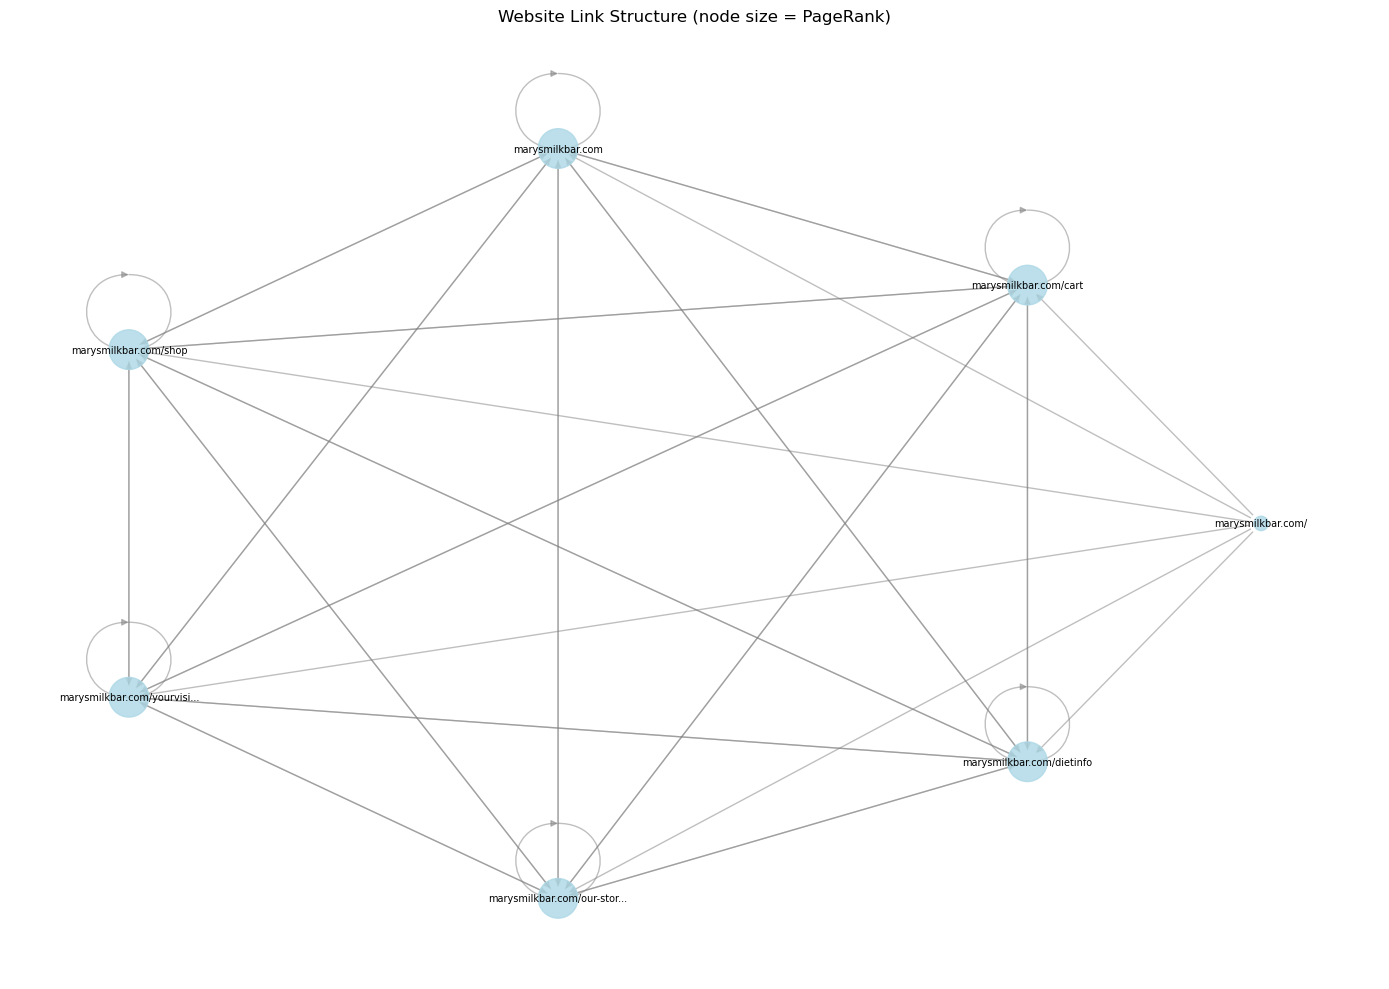

In [10]:
def improved_graph_visualization(pages_info):
    """
    Create a cleaner, more readable graph visualization.
    """
    # Create the graph with shortened labels
    graph = nx.DiGraph()
    label_map = {}  # Map full URLs to short labels
    
    for page in pages_info:
        origin = page['address']
        origin_short = shorten_url(origin)
        label_map[origin_short] = origin
        
        for dest in page['links_to']:
            dest_short = shorten_url(dest)
            label_map[dest_short] = dest
            graph.add_edge(origin_short, dest_short)
    
    # Calculate PageRank for node sizing
    if graph.number_of_nodes() > 0:
        pageranks = nx.pagerank(graph)
        sizes = [pageranks.get(n, 0.01) * 5000 for n in graph.nodes()]
    else:
        sizes = [300] * graph.number_of_nodes()
    
    # Create larger figure
    plt.figure(figsize=(14, 10))
    
    # Try different layouts - kamada_kawai often looks cleaner
    try:
        positions = nx.kamada_kawai_layout(graph)
    except:
        positions = nx.spring_layout(graph, k=2, seed=42)
    
    # Draw with styling
    nx.draw_networkx_nodes(graph, positions, 
                           node_size=sizes, 
                           node_color='lightblue',
                           alpha=0.8)
    nx.draw_networkx_edges(graph, positions, 
                           edge_color='gray', 
                           arrows=True,
                           arrowsize=10,
                           alpha=0.5)
    nx.draw_networkx_labels(graph, positions, font_size=7)
    
    plt.title("Website Link Structure (node size = PageRank)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return graph, pageranks

# Try the improved visualization
graph, pageranks = improved_graph_visualization(scraped_pages)

---

# Step 5: Analyze Your Results

After crawling, answer these analysis questions about the website you crawled.

## PageRank Analysis

In [11]:
# Display PageRank scores
print("PageRank Scores (sorted):")
print("=" * 50)
for page, score in sorted(pageranks.items(), key=lambda x: x[1], reverse=True):
    print(f"{page:40} {score:.4f}")

PageRank Scores (sorted):
marysmilkbar.com/cart                    0.1631
marysmilkbar.com                         0.1631
marysmilkbar.com/shop                    0.1631
marysmilkbar.com/yourvisi...             0.1631
marysmilkbar.com/our-stor...             0.1631
marysmilkbar.com/dietinfo                0.1631
marysmilkbar.com/                        0.0214


## HITS Analysis

In [12]:
# Calculate HITS scores
hubs, authorities = nx.hits(graph)

print("Hub Scores (pages that link to many):")
print("-" * 50)
for page, score in sorted(hubs.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{page:40} {score:.4f}")

print("\nAuthority Scores (pages linked to by many):")
print("-" * 50)
for page, score in sorted(authorities.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{page:40} {score:.4f}")

Hub Scores (pages that link to many):
--------------------------------------------------
marysmilkbar.com/                        0.1429
marysmilkbar.com/cart                    0.1429
marysmilkbar.com                         0.1429
marysmilkbar.com/shop                    0.1429
marysmilkbar.com/yourvisi...             0.1429

Authority Scores (pages linked to by many):
--------------------------------------------------
marysmilkbar.com/cart                    0.1667
marysmilkbar.com                         0.1667
marysmilkbar.com/shop                    0.1667
marysmilkbar.com/yourvisi...             0.1667
marysmilkbar.com/our-stor...             0.1667


## Questions to Answer

Think about and answer these questions in the cells below:

1. **Structure**: How many pages did you discover? Are there clusters of related pages?

2. **Dead Ends**: Which pages have no outgoing links? Why might a website have dead-end pages?

3. **Central Pages**: Which page has the highest PageRank? Does this make sense for the website's purpose?

4. **Hub vs Authority**: Which page is the best hub? Which is the best authority? Are they the same or different?

5. **Business Insight**: If this were your company's website, what would you recommend improving based on the link structure?

*Write your answers here:*

1. **Structure**: 

2. **Dead Ends**: 

3. **Central Pages**: 

4. **Hub vs Authority**: 

5. **Business Insight**: 

---

# Your Challenge: Try Different Websites

Now it's your turn! Try crawling different websites and analyzing their structure.

## Recommended Websites for Practice

| Website | Difficulty | Notes |
|---------|------------|-------|
| https://www.marysmilkbar.com/ | Easy | Small, static site |
| https://www.soderberg.uk/ | Easy | Small bakery site |
| https://quotes.toscrape.com/ | Easy | Designed for scraping practice |
| https://books.toscrape.com/ | Medium | More pages, pagination |
| https://www.edinburghshogmanay.com/ | Medium | Event website |
| https://gauss.world/ | Medium | Personal website |
| https://bagrow.com/ | Medium | Academic website |

## Websites to Avoid

- **Large sites** (BBC, Amazon) - too many pages, will take forever
- **JavaScript-heavy sites** - require Playwright, not just requests
- **Sites with aggressive rate limiting** - might block you
- **Sites that explicitly disallow crawling** - check robots.txt!

Looking for links in https://www.soderberg.uk/
Looking for links in https://www.soderberg.uk/events-edinburgh
Looking for links in https://www.soderberg.uk/jazz-sundays
Looking for links in https://www.soderberg.uk/sderberg-east-dulwich
Looking for links in https://www.soderberg.uk/swedish-cinnamon-bun-baking-parties-east-dulwich
Looking for links in https://www.soderberg.uk/the-bakery-1
Looking for links in https://www.soderberg.uk/christmasedinburgh
Looking for links in https://www.soderberg.uk/work-with-us
Looking for links in https://www.soderberg.uk/welcome-to-soderberg-wandsworth
Looking for links in https://www.soderberg.uk/our-cafes
Looking for links in https://www.soderberg.uktel:01312285876
  Error: Failed to parse: https://www.soderberg.uktel:01312285876
Looking for links in https://www.soderberg.uk/soderberg-pavilion
Looking for links in https://www.soderberg.uk/masterclasses-london
Looking for links in https://www.soderberg.uk/s/Drinks-Menu-East-Dulwich-060126.pdf
  Error:

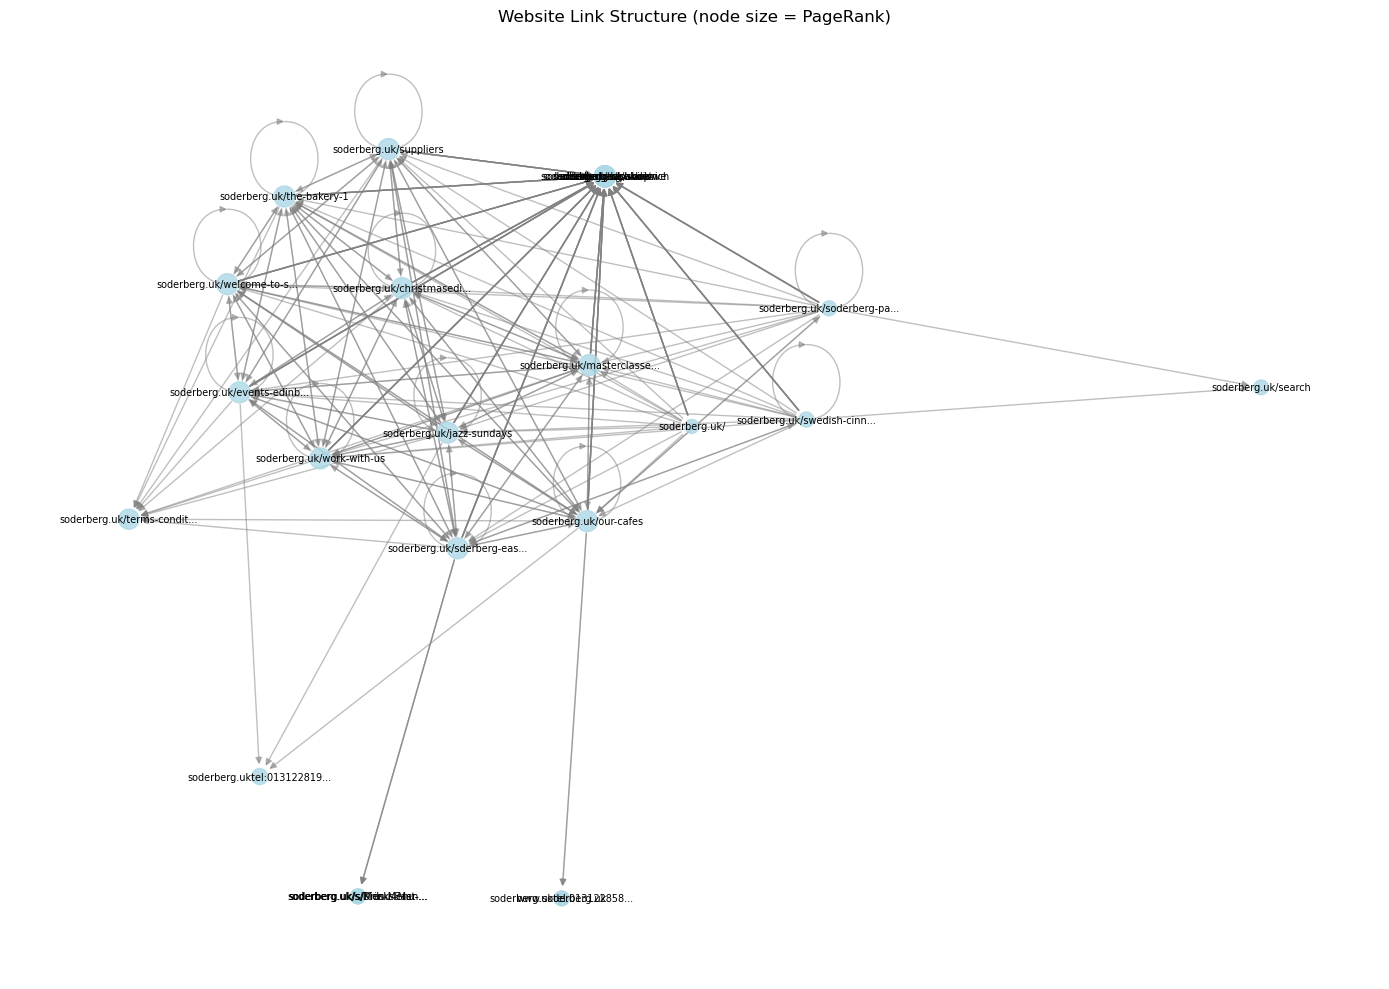

In [13]:
# YOUR CHALLENGE: Crawl and analyze a different website
# ======================================================

# Choose a website from the list above (or find your own small site)
my_website = "https://www.soderberg.uk/"  # Change this!

# Crawl it (adjust max_pages as needed)
my_pages = analyse_website(my_website, max_pages=15)

# Visualize
my_graph, my_pageranks = improved_graph_visualization(my_pages)

In [14]:
# Analyze your results
print("Top 5 pages by PageRank:")
for page, score in sorted(my_pageranks.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"  {page}: {score:.4f}")

# Your analysis here...

Top 5 pages by PageRank:
  soderberg.uk: 0.0455
  soderberg.uk/masterclasse...: 0.0455
  soderberg.uk/christmasedi...: 0.0455
  soderberg.uk/about: 0.0455
  soderberg.uk/east-dulwich: 0.0455


---

## Bonus: Try with External Links

See what happens when you allow the crawler to follow external links!

Looking for links in https://www.soderberg.uk/
Looking for links in https://www.instagram.com/soderbergbakery
Looking for links in https://www.soderberg.uk/events-edinburgh
Looking for links in https://www.soderberg.uk/the-bakery-1
Looking for links in https://www.soderberg.uk/christmasedinburgh
Looking for links in https://www.soderberg.uk/jazz-sundays
Looking for links in https://www.soderberg.uk/work-with-us
Looking for links in https://www.soderberg.uk/sderberg-east-dulwich
Looking for links in https://www.google.com/search
Looking for links in https://www.soderberg.uk/swedish-cinnamon-bun-baking-parties-east-dulwich
Looking for links in https://accounts.google.com/ServiceLogin
Looking for links in https://accounts.google.com/TOS
Looking for links in https://adssettings.google.com
Looking for links in https://consent.google.com/m
Looking for links in https://myaccount.google.com/activitycontrols

Crawl complete! Visited 15 pages.


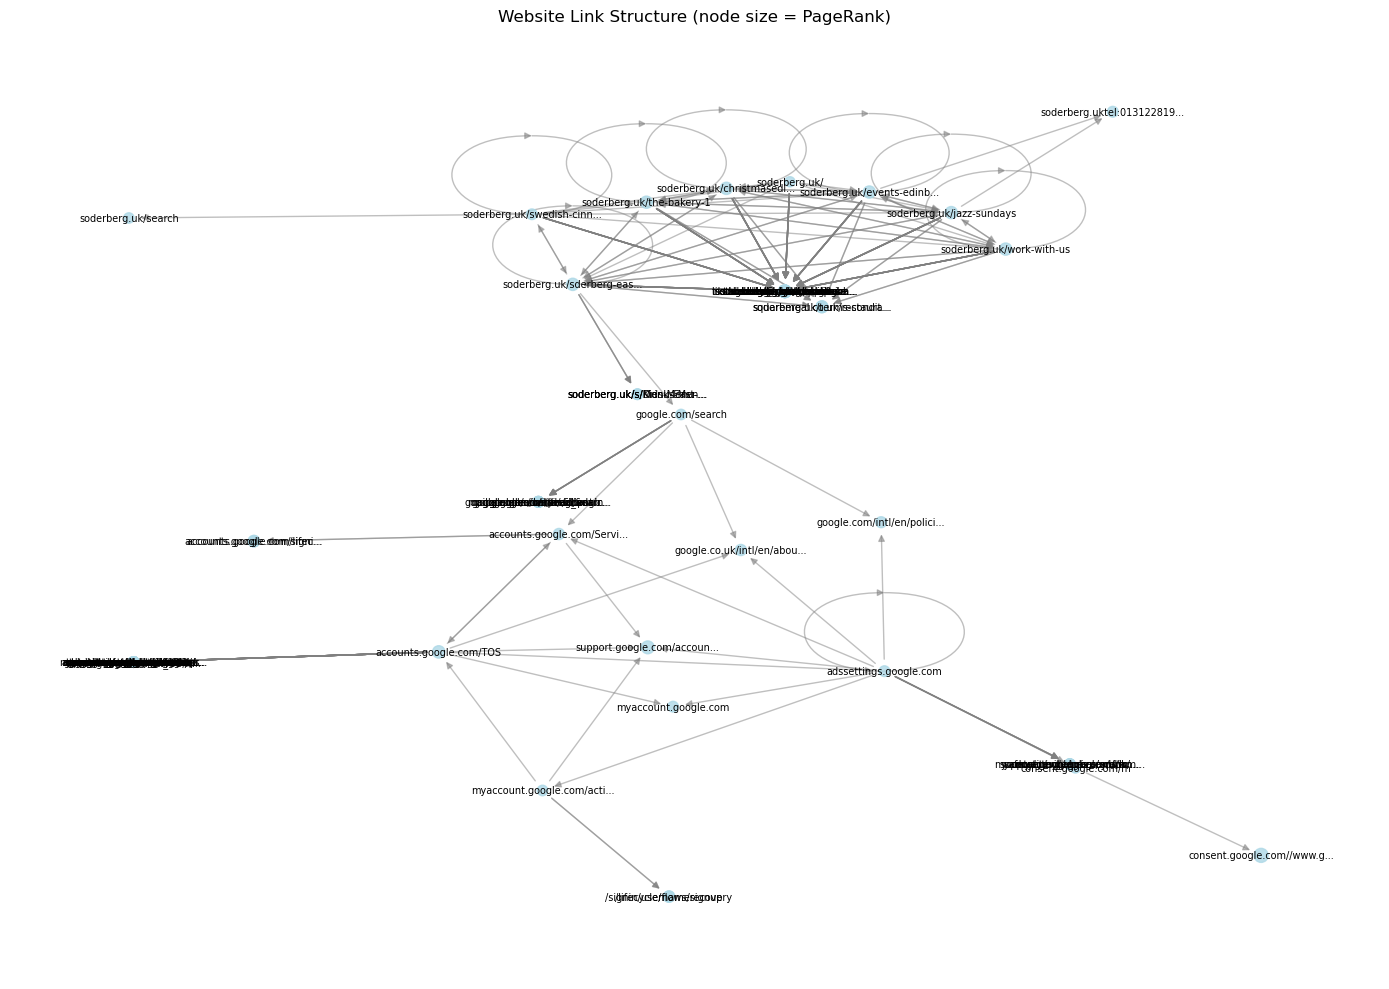

(<networkx.classes.digraph.DiGraph at 0x7f79f41830e0>,
 {'soderberg.uk/': 0.010743636853731085,
  'soderberg.uk': 0.015512092843543246,
  'soderberg.uk/who-are-we': 0.015512092843543246,
  'soderberg.uk/shop': 0.015512092843543246,
  'soderberg.uk/welcome-to-s...': 0.015512092843543246,
  'soderberg.uk/east-dulwich': 0.015512092843543246,
  'soderberg.uk/our-cafes': 0.015512092843543246,
  'soderberg.uk/events-edinb...': 0.015512092843543246,
  'soderberg.uk/masterclasse...': 0.015512092843543246,
  'soderberg.uk/pavilion': 0.015512092843543246,
  'tiktok.com/@soderbergbake...': 0.015512092843543246,
  'soderberg.uk/suppliers': 0.015512092843543246,
  'soderberg.uk/sderberg-eas...': 0.015512092843543246,
  'soderberg.uk/work-with-us': 0.015512092843543246,
  'soderberg.uk/jazz-sundays': 0.015512092843543246,
  'soderberg.uk/christmasedi...': 0.015512092843543246,
  'soderberg.uk/about': 0.015512092843543246,
  'soderberg.uk/the-bakery-1': 0.015512092843543246,
  'instagram.com/soderber

In [15]:
# Caution: This will crawl across domains!
# Keep max_pages LOW to avoid crawling the entire internet

pages_with_external = analyse_website("https://www.soderberg.uk/", 
                                       keep_external_links=True, 
                                       max_pages=15)

# Notice how it expands to social media links, etc.
improved_graph_visualization(pages_with_external)

### Think about how to improve the visualisation!!!

---

## Summary

Congratulations! You've completed the APC2 challenge. You now know how to:

1. Handle different URL formats when crawling remote websites
2. Filter links to stay within a domain
3. Limit crawling to avoid infinite loops
4. Create readable graph visualizations
5. Analyze website structure using PageRank and HITS

These skills will be useful for the final assessment!